In [1]:
# Setup (PyTorch, paths, device, seeds)
%load_ext autoreload
%autoreload 2

from xray_models import (
    PneumoCNN, eval_one_epoch, fit,
    pick_threshold_youden, evaluate_with_threshold
)

from xray_helpers import (
    seed_all, compute_pos_weight,
    balance_val_train_split, plot_curves, get_dataloaders, download_xray_dataset
)

import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 15
PATIENCE = int(EPOCHS * 2 / 3)
LR = 1e-4

In [4]:
base_dir, train_dir, val_dir, test_dir = download_xray_dataset()

Train dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Train dir contents: ['PNEUMONIA', 'NORMAL']
Val dir: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Val dir contents: ['PNEUMONIA', 'NORMAL']
Test dir: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Test dir contents: ['PNEUMONIA', 'NORMAL']


Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


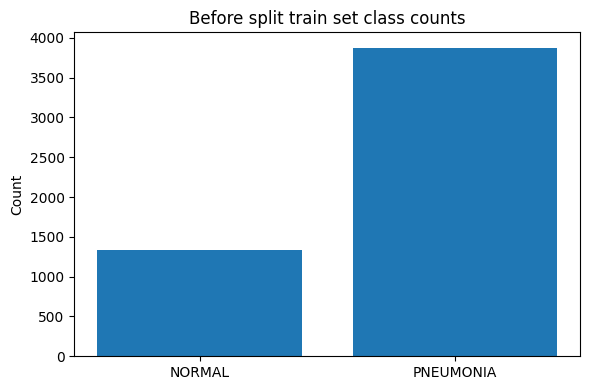

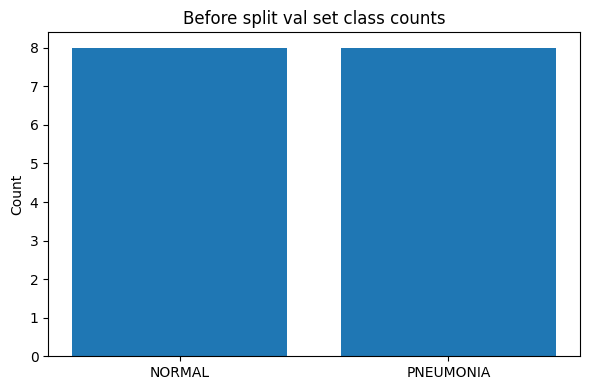

After split:
train/NORMAL: 1147
train/PNEUMONIA: 3300
val/NORMAL: 202
val/PNEUMONIA: 583


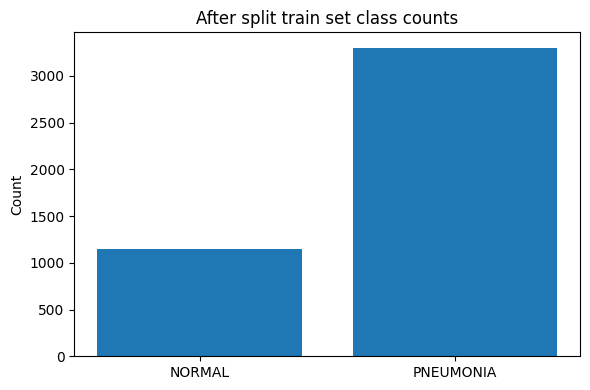

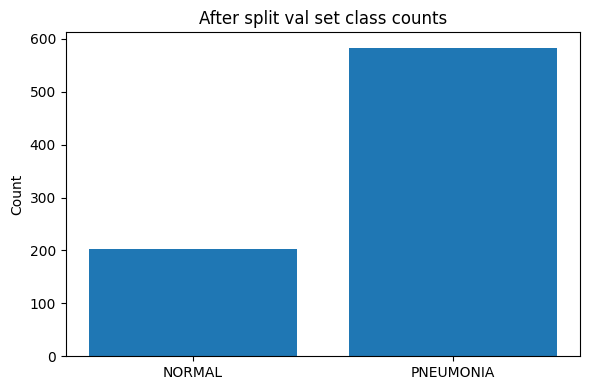

New dir: /tmp/chest_xray_split


In [5]:
new_base = balance_val_train_split(base_dir)
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')

In [6]:
model = PneumoCNN()
model = model.to(device)

data_sets, loaders = get_dataloaders(train_dir, val_dir, test_dir, IMG_SIZE, BATCH_SIZE, NUM_WORKERS)

print(f"Classes => {data_sets['train_ds'].classes}, , Class indices => {data_sets['train_ds'].class_to_idx}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 23.3MB/s]


Classes => ['NORMAL', 'PNEUMONIA'], , Class indices => {'NORMAL': 0, 'PNEUMONIA': 1}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


[Eval] Epoch 1/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 1/15: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


Train Loss: 0.6599, Accuracy: 0.6047, AUC: 0.5412
Val Loss: 0.6373, Accuracy: 0.7427, AUC: 0.4385


[Train] Epoch 2/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 2/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Train Loss: 0.5604, Accuracy: 0.7252, AUC: 0.6372
Val Loss: 0.6242, Accuracy: 0.7427, AUC: 0.5240


[Train] Epoch 3/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 3/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Train Loss: 0.5443, Accuracy: 0.7284, AUC: 0.6676
Val Loss: 1.6210, Accuracy: 0.7401, AUC: 0.4172


[Train] Epoch 4/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 4/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Train Loss: 0.5384, Accuracy: 0.7331, AUC: 0.6731
Val Loss: 1.5296, Accuracy: 0.7376, AUC: 0.4257


[Train] Epoch 5/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 5/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Train Loss: 0.5325, Accuracy: 0.7362, AUC: 0.6872
Val Loss: 2.5327, Accuracy: 0.7363, AUC: 0.4137


[Train] Epoch 6/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 6/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Train Loss: 0.5270, Accuracy: 0.7394, AUC: 0.6966
Val Loss: 2.4931, Accuracy: 0.7389, AUC: 0.4178


[Train] Epoch 7/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 7/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Train Loss: 0.5259, Accuracy: 0.7400, AUC: 0.6971
Val Loss: 2.1556, Accuracy: 0.7363, AUC: 0.4128


[Train] Epoch 8/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 8/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Train Loss: 0.5252, Accuracy: 0.7394, AUC: 0.6972
Val Loss: 1.4718, Accuracy: 0.7363, AUC: 0.4005


[Train] Epoch 9/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 9/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Train Loss: 0.5261, Accuracy: 0.7385, AUC: 0.7004
Val Loss: 1.5079, Accuracy: 0.7350, AUC: 0.4002


[Train] Epoch 10/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 10/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze i

Train Loss: 0.5127, Accuracy: 0.7396, AUC: 0.7165
Val Loss: 1.5111, Accuracy: 0.7363, AUC: 0.3894


[Train] Epoch 11/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 11/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze i

Train Loss: 0.5217, Accuracy: 0.7351, AUC: 0.7031
Val Loss: 1.6212, Accuracy: 0.7338, AUC: 0.4014


[Train] Epoch 12/15:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 12/15:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze i

Train Loss: 0.5186, Accuracy: 0.7407, AUC: 0.7075
Val Loss: 1.4623, Accuracy: 0.7350, AUC: 0.3993
Early stopping at epoch 12. Best val AUC=0.5240
Training finished in 5.5 min. Best val AUC: 0.5240


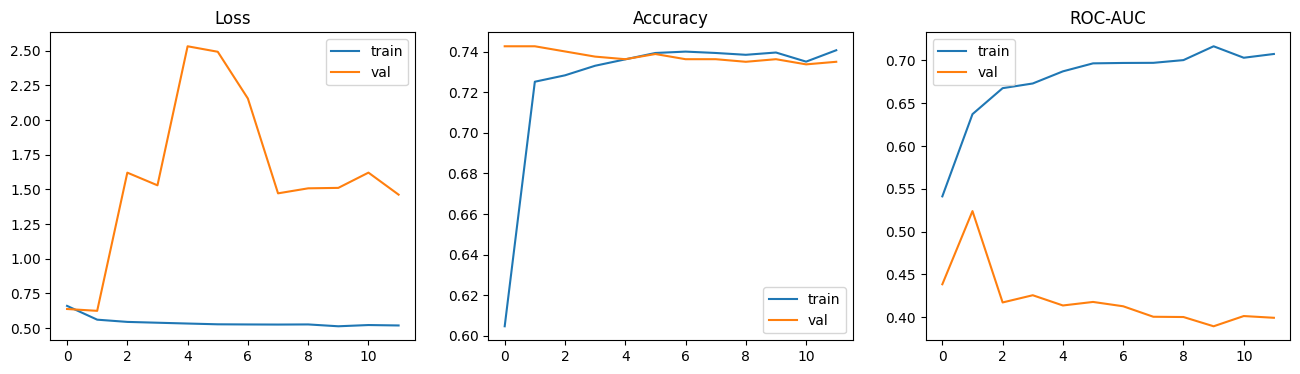

In [7]:
pos_weight = compute_pos_weight(data_sets['train_ds'])
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

history, best_val_auc = fit(model, loaders['train_loader'], loaders['val_loader'],
                            criterion, optimizer, device, scheduler, epochs=EPOCHS, patience=PATIENCE)

plot_curves(history)

In [8]:
_, _, va_auc, va_probs, va_targets = eval_one_epoch(model, loaders['val_loader'], 1, criterion, device, 1)
best_thr = pick_threshold_youden(va_targets, va_probs)
print("Chosen threshold:", best_thr)

[Eval] Epoch 1/1:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 1/1: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]

Chosen threshold: 0.6014957427978516


[Eval] Epoch 1/15:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[Eval] Epoch 1/15: 100%|██████████| 3/3 [00:11<00:00,  3.95s/it]


probs[:10] = [0.9466969  0.9793906  0.8910798  0.9304311  0.98732924 0.9427308
 0.93072134 0.81009215 0.978105   0.59640634]
targets[:10] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TEST — loss: 0.8785 | acc@thr: 0.5769 | auc: 0.4087
Specificity: 0.1239 | Sensitivity: 0.8487 | Balanced Acc: 0.4863 | PR-AUC: 0.5383
Confusion Matrix:
 [[ 29 205]
 [ 59 331]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.3295    0.1239    0.1801       234
   PNEUMONIA     0.6175    0.8487    0.7149       390

    accuracy                         0.5769       624
   macro avg     0.4735    0.4863    0.4475       624
weighted avg     0.5095    0.5769    0.5144       624



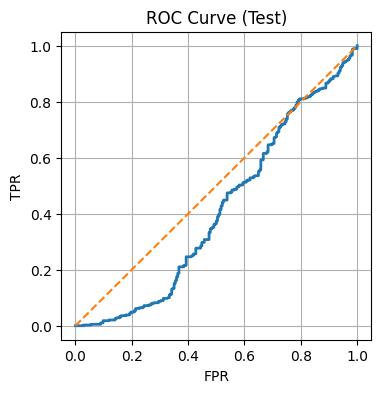

In [9]:
evaluate_with_threshold(model, loaders['test_loader'], criterion, best_thr, device, EPOCHS)